# Import

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

In [2]:
path = '/path/to/data/SQANTI_reports'

In [ ]:
config_path = "/path/to/code/snakemake-pipeline/config/config.yaml"
with open(config_path) as conf:
    config = yaml.load(conf, Loader=yaml.FullLoader)
    conf.close()

In [4]:
TISSUES = ['aorta', 'colon', 'brain', 'heart', 'lung', 'muscle']
TOOLS = config['tools']
version = 2
if version == 'isotools':
    # Filter out all non isotools tools
    TOOLS = [t for t in TOOLS if 'isotools' in t]
else:
    # Filter out all isotools versions except the version
    TOOLS = [t for t in TOOLS if 'isotools_v' not in t or int(t.replace('isotools_v', '')) == version]

tissue = 'aorta'
tool = 'isoquant'

In [5]:
plot_directory = os.path.join('/home/lankenau/Vault/Images/plots/', f'v{version}')
os.makedirs(plot_directory, exist_ok=True)
plot_directory

'/home/lankenau/Vault/Images/plots/v2'

In [6]:
df = pd.read_csv(os.path.join(path, f'{tissue}_{tool}_classification.txt'), sep='\t')
df.head()

isoform chrom strand  length  exons structural_category  \
0  ENST00000003583.12  chr1      -    2544      8   full-splice_match   
1  ENST00000037502.11  chr1      -    2100      3   full-splice_match   
2   ENST00000040877.2  chr1      -    5206     30   full-splice_match   
3  ENST00000054666.11  chr1      +    2178      5   full-splice_match   
4   ENST00000060969.6  chr1      -    5494      5   full-splice_match   

      associated_gene associated_transcript  ref_length  ref_exons  ...  \
0  ENSG00000001460.18    ENST00000003583.12      2544.0        8.0  ...   
1  ENSG00000034971.17    ENST00000037502.11      2100.0        3.0  ...   
2  ENSG00000059588.10     ENST00000040877.2      5206.0       30.0  ...   
3  ENSG00000049245.13    ENST00000054666.11      2178.0        5.0  ...   
4  ENSG00000052723.12     ENST00000060969.6      5494.0        5.0  ...   

   seq_A_downstream_TTS  dist_to_CAGE_peak  within_CAGE_peak  \
0  TATTGAGCTTTTGGGTACCC               -1.0              True   
1  CGTTCTCTTCCTTGAACTTT             2311.0             False   
2  TTTATTTCCTAGAAACGCCT               -1.0              True   
3  TTGTGGCACCTGTGCTCCTT                0.0              True   
4  TCCTTGCTAATATTTTACTT               14.0             False   

   dist_to_polyA_site within_polyA_site  polyA_motif polyA_dist  \
0               -23.0              True       ATTAAA      -16.0   
1               -14.0              True       AATAAA      -15.0   
2               -10.0              True       AATAAA      -24.0   
3                32.0              True       AATAAA      -17.0   
4               -24.0              True       AATAAA      -21.0   

   polyA_motif_found  ORF_seq    ratio_TSS  
0               True      NaN   201.000000  
1               True      NaN  2751.000000  
2               True      NaN          NaN  
3               True      NaN  2527.237624  
4               True      NaN   801.000000  

[5 rows x 48 columns]

In [7]:
df.columns

Index(['isoform', 'chrom', 'strand', 'length', 'exons', 'structural_category',
       'associated_gene', 'associated_transcript', 'ref_length', 'ref_exons',
       'diff_to_TSS', 'diff_to_TTS', 'diff_to_gene_TSS', 'diff_to_gene_TTS',
       'subcategory', 'RTS_stage', 'all_canonical', 'min_sample_cov',
       'min_cov', 'min_cov_pos', 'sd_cov', 'FL', 'n_indels', 'n_indels_junc',
       'bite', 'iso_exp', 'gene_exp', 'ratio_exp', 'FSM_class', 'coding',
       'ORF_length', 'CDS_length', 'CDS_start', 'CDS_end', 'CDS_genomic_start',
       'CDS_genomic_end', 'predicted_NMD', 'perc_A_downstream_TTS',
       'seq_A_downstream_TTS', 'dist_to_CAGE_peak', 'within_CAGE_peak',
       'dist_to_polyA_site', 'within_polyA_site', 'polyA_motif', 'polyA_dist',
       'polyA_motif_found', 'ORF_seq', 'ratio_TSS'],
      dtype='object')

In [8]:
# speeds up import when reexecuting
classifications = {} if not 'classifications' in globals() else classifications

def get_classification(tissue, tool) -> pd.DataFrame:
    if not tissue in classifications:
        classifications[tissue] = {}
    if not tool in classifications[tissue]:
        classifications[tissue][tool] = pd.read_csv(os.path.join(path, f'{tissue}_{tool}_classification.txt'), sep='\t')
    return classifications[tissue][tool]

In [9]:
all = pd.DataFrame()
for tissue in TISSUES:
    for tool in TOOLS:
        df = get_classification(tissue, tool).copy()
        df.insert(0, 'tissue', tissue)
        if tool == 'isotools_v0' and version == 0:
            df.insert(1, 'tool', 'isotools')
        else:
            df.insert(1, 'tool', tool)
        # Rename and make boolean
        df['category'] = df['structural_category']
        df['TSS ratio'] = df['ratio_TSS'] > 1.5
        df['CAGE support'] = df['within_CAGE_peak']
        df['polyA site'] = df['within_polyA_site']
        df['polyA motif'] = df['polyA_motif_found']
        df['start both'] = df['TSS ratio'] & df['CAGE support']
        df['end both'] = df['polyA site'] & df['polyA motif']
        all = pd.concat([all, df], ignore_index=True)

In [10]:
# Rename categories
all['category'] = all['category'].replace({
    'intergenic': 'Intergenic',
    'antisense': 'Antisense',
    'genic': 'Genic',
    'genic_intron': 'Genic Intron',
    'fusion': 'Fusion',
    'full-splice_match': 'FSM',
    'incomplete-splice_match': 'ISM',
    'novel_in_catalog': 'NIC',
    'novel_not_in_catalog': 'NNC'
})

In [11]:
all

tissue       tool             isoform chrom strand  length  exons  \
0         aorta      flair  ENST00000037502.11  chr1      -    2100      3   
1         aorta      flair   ENST00000040877.2  chr1      -    5180     30   
2         aorta      flair  ENST00000054666.11  chr1      +    2178      5   
3         aorta      flair   ENST00000060969.6  chr1      -    1414      5   
4         aorta      flair   ENST00000072644.7  chr1      -    1822     11   
...         ...        ...                 ...   ...    ...     ...    ...   
3062962  muscle  stringtie       MSTRG.25759.2  chrY      +    3708      8   
3062963  muscle  stringtie       MSTRG.25759.3  chrY      +    1205      9   
3062964  muscle  stringtie       MSTRG.25759.4  chrY      +    1322     12   
3062965  muscle  stringtie       MSTRG.25759.5  chrY      +    1976     10   
3062966  muscle  stringtie       MSTRG.25760.1  chrY      -    1108      1   

          structural_category     associated_gene associated_transcript  ...  \
0           full-splice_match  ENSG00000034971.17    ENST00000037502.11  ...   
1           full-splice_match  ENSG00000059588.10     ENST00000040877.2  ...   
2           full-splice_match  ENSG00000049245.13    ENST00000054666.11  ...   
3           full-splice_match  ENSG00000052723.12     ENST00000060969.6  ...   
4           full-splice_match  ENSG00000058799.15     ENST00000072644.7  ...   
...                       ...                 ...                   ...  ...   
3062962      novel_in_catalog   ENSG00000292348.1                 novel  ...   
3062963      novel_in_catalog   ENSG00000292348.1                 novel  ...   
3062964      novel_in_catalog   ENSG00000292348.1                 novel  ...   
3062965  novel_not_in_catalog   ENSG00000292348.1                 novel  ...   
3062966          genic_intron       novelGene_606                 novel  ...   

         polyA_motif_found  ORF_seq    ratio_TSS      category  TSS ratio  \
0                     True      NaN  2751.000000           FSM       True   
1                     True      NaN          NaN           FSM      False   
2                     True      NaN  2527.237624           FSM       True   
3                     True      NaN     7.842750           FSM       True   
4                     True      NaN   255.455446           FSM       True   
...                    ...      ...          ...           ...        ...   
3062962               True      NaN  1051.000000           NIC       True   
3062963               True      NaN  1051.000000           NIC       True   
3062964               True      NaN  1201.000000           NIC       True   
3062965               True      NaN  1201.000000           NNC       True   
3062966               True      NaN     0.980124  Genic Intron      False   

         CAGE support polyA site  polyA motif start both  end both  
0               False       True         True      False      True  
1                True       True         True      False      True  
2                True       True         True       True      True  
3               False       True         True      False      True  
4               False       True         True      False      True  
...               ...        ...          ...        ...       ...  
3062962         False      False         True      False     False  
3062963         False      False         True      False     False  
3062964         False      False         True      False     False  
3062965         False      False         True      False     False  
3062966         False      False         True      False     False  

[3062967 rows x 57 columns]

# Transcript Counts

Barplot for the number of isoforms for each tool and tissue

In [12]:
agg_all = all.groupby(['tool', 'tissue']).agg({'TSS ratio': 'sum', 'CAGE support': 'sum', 'polyA site': 'sum', 'polyA motif': 'sum', 'start both': 'sum', 'end both': 'sum', 'isoform': 'count'}).reset_index()
agg_all['count'] = agg_all['isoform']

agg_by_category = all.groupby(['tool', 'tissue', 'category']).agg({'TSS ratio': 'sum', 'CAGE support': 'sum', 'polyA site': 'sum', 'polyA motif': 'sum', 'start both': 'sum', 'end both': 'sum', 'isoform': 'count'}).reset_index()
agg_by_category['count'] = agg_by_category['isoform']

agg_by_subcategory = all.groupby(['tool', 'tissue', 'category', 'subcategory']).agg({'TSS ratio': 'sum', 'CAGE support': 'sum', 'polyA site': 'sum', 'polyA motif': 'sum', 'start both': 'sum', 'end both': 'sum', 'isoform': 'count'}).reset_index()
agg_by_subcategory['count'] = agg_by_subcategory['isoform']

In [13]:
agg_by_category

tool  tissue      category  TSS ratio  CAGE support  polyA site  \
0        flair   aorta     Antisense        971            31         803   
1        flair   aorta           FSM      14902          9402       18178   
2        flair   aorta        Fusion        211           111         244   
3        flair   aorta         Genic       1143           544        1173   
4        flair   aorta  Genic Intron        612            45        1658   
..         ...     ...           ...        ...           ...         ...   
211  stringtie  muscle  Genic Intron         22             6          32   
212  stringtie  muscle           ISM         19            20          36   
213  stringtie  muscle    Intergenic         51             6          47   
214  stringtie  muscle           NIC       2433          1447        3180   
215  stringtie  muscle           NNC        963           570        1184   

     polyA motif  start both  end both  isoform  count  
0           3647           5       430    13301  13301  
1          17716        7634     16379    21524  21524  
2            248          90       206      365    365  
3           2203         417       772     6161   6161  
4           9307           1       836    33049  33049  
..           ...         ...       ...      ...    ...  
211          108           1        22      416    416  
212           32          10        28       46     46  
213           90           3        39      190    190  
214         3203        1200      2995     3636   3636  
215         1285         445      1117     1488   1488  

[216 rows x 11 columns]

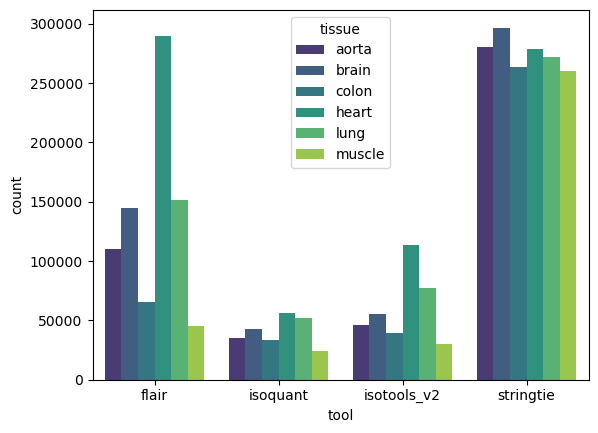

In [14]:
ax1 = sns.barplot(x='tool', y='count', hue='tissue', data=agg_all, palette='viridis')
# ax1.set_title('Number of isoforms by tool and tissue')
plt.savefig(os.path.join(plot_directory, 'transcript_counts.png'))

# Category Counts

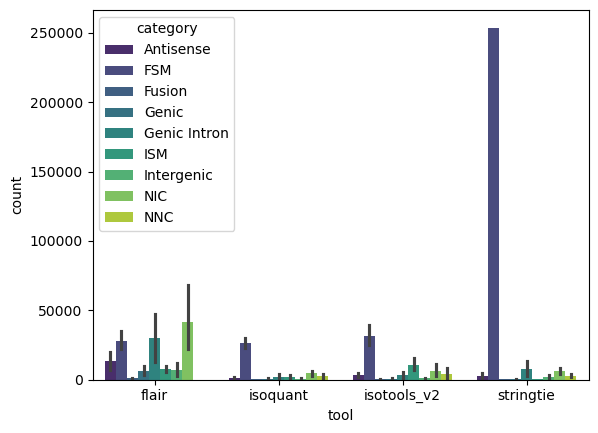

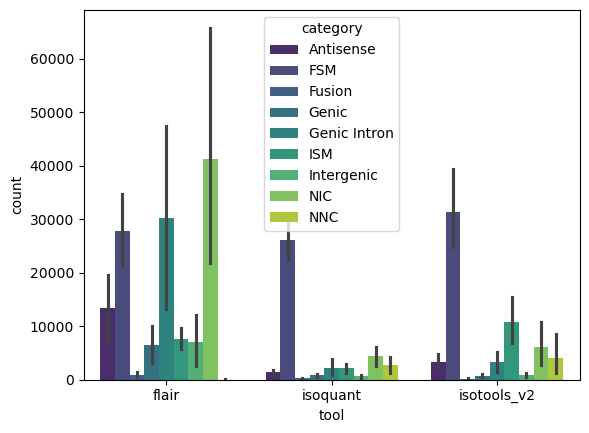

In [15]:
# Counts per category
ax1 = sns.barplot(x='tool', y='count', hue='category', data=agg_by_category, palette='viridis')
plt.show()
no_stringtie = ~agg_by_category['tool'].isin(['stringtie'])
ax1 = sns.barplot(x='tool', y='count', hue='category', data=agg_by_category[no_stringtie], palette='viridis')

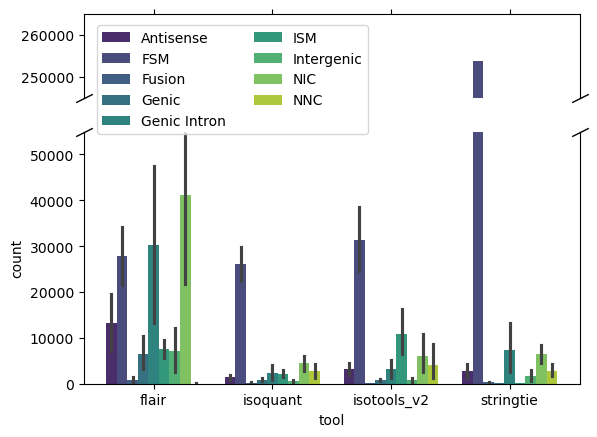

In [16]:
# Based on https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': (1, 3)})
sns.barplot(x='tool', y='count', hue='category', data=agg_by_category, palette='viridis', ax=ax1, legend=False)
# ax1.set_title('Number of isoforms by tool and category')
ax1.set_ylabel('')
sns.barplot(x='tool', y='count', hue='category', data=agg_by_category, palette='viridis', ax=ax2)
ax2.legend(loc='upper center', bbox_to_anchor=(0.3, 1.45), ncol=2)

ax1.set_ylim(245_000, 265_000)  # outliers only
ax2.set_ylim(0, 55_000)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig(os.path.join(plot_directory, 'transcript_counts_category.png'))
plt.show()

In [17]:
# Number of FSMs of StringTie in each tissue
agg_by_category[(agg_by_category['tool'] == 'stringtie') & (agg_by_category['category'] == 'FSM')]

tool  tissue category  TSS ratio  CAGE support  polyA site  \
163  stringtie   aorta      FSM      73270         36721      121411   
172  stringtie   brain      FSM      82558         43997      120564   
181  stringtie   colon      FSM      78157         40298      121857   
190  stringtie   heart      FSM      92129         30626      120865   
199  stringtie    lung      FSM      85016         39101      121545   
208  stringtie  muscle      FSM      68739         34979      121646   

     polyA motif  start both  end both  isoform   count  
163       144379       24898     99891   253740  253740  
172       144001       30553     99175   253721  253721  
181       145053       28438    100581   253744  253744  
190       144235       26283     99451   253745  253745  
199       144880       29813    100325   253736  253736  
208       144292       24499    100016   253777  253777

In [18]:
# Mean counts per category
agg_by_category.groupby(['tool', 'category']).agg(count_mean=('count', 'mean')).reset_index()

tool      category     count_mean
0         flair     Antisense   13296.833333
1         flair           FSM   27774.333333
2         flair        Fusion     850.666667
3         flair         Genic    6425.833333
4         flair  Genic Intron   30149.833333
5         flair           ISM    7648.333333
6         flair    Intergenic    7088.166667
7         flair           NIC   41260.666667
8         flair           NNC      11.000000
9      isoquant     Antisense    1357.000000
10     isoquant           FSM   26049.666667
11     isoquant        Fusion     213.166667
12     isoquant         Genic     772.666667
13     isoquant  Genic Intron    2216.500000
14     isoquant           ISM    2185.833333
15     isoquant    Intergenic     590.333333
16     isoquant           NIC    4411.500000
17     isoquant           NNC    2687.500000
18  isotools_v2     Antisense    3235.833333
19  isotools_v2           FSM   31400.333333
20  isotools_v2        Fusion     124.333333
21  isotools_v2         Genic     761.500000
22  isotools_v2  Genic Intron    3205.000000
23  isotools_v2           ISM   10725.500000
24  isotools_v2    Intergenic     800.166667
25  isotools_v2           NIC    6081.833333
26  isotools_v2           NNC    4014.166667
27    stringtie     Antisense    2804.166667
28    stringtie           FSM  253743.833333
29    stringtie        Fusion     287.833333
30    stringtie         Genic      66.666667
31    stringtie  Genic Intron    7435.000000
32    stringtie           ISM     106.833333
33    stringtie    Intergenic    1615.500000
34    stringtie           NIC    6357.500000
35    stringtie           NNC    2738.666667

## Subcategory counts

In [19]:
agg_by_subcategory

tool  tissue   category                       subcategory  \
0        flair   aorta  Antisense                         mono-exon   
1        flair   aorta        FSM                  alternative_3end   
2        flair   aorta        FSM              alternative_3end5end   
3        flair   aorta        FSM                  alternative_5end   
4        flair   aorta        FSM                         mono-exon   
..         ...     ...        ...                               ...   
549  stringtie  muscle        NIC  combination_of_known_splicesites   
550  stringtie  muscle        NIC                  intron_retention   
551  stringtie  muscle        NIC     mono-exon_by_intron_retention   
552  stringtie  muscle        NNC     at_least_one_novel_splicesite   
553  stringtie  muscle        NNC                  intron_retention   

     TSS ratio  CAGE support  polyA site  polyA motif  start both  end both  \
0          971            31         803         3647           5       430   
1         5778          3695        6158         5579        3102      5166   
2         1356           747        1828         1712         562      1538   
3         1280           754        1928         1924         582      1843   
4          552           286        1051         1314         180       880   
..         ...           ...         ...          ...         ...       ...   
549        522           297         667          676         250       637   
550        443           272         599          603         224       563   
551          5             0           8           13           0         7   
552        833           492        1022         1110         380       962   
553        130            78         162          175          65       155   

     isoform  count  
0      13301  13301  
1       7237   7237  
2       2323   2323  
3       2047   2047  
4       2390   2390  
..       ...    ...  
549      752    752  
550      690    690  
551       27     27  
552     1283   1283  
553      205    205  

[554 rows x 12 columns]

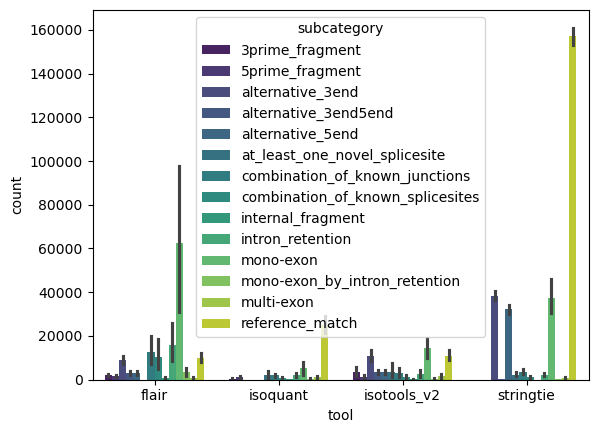

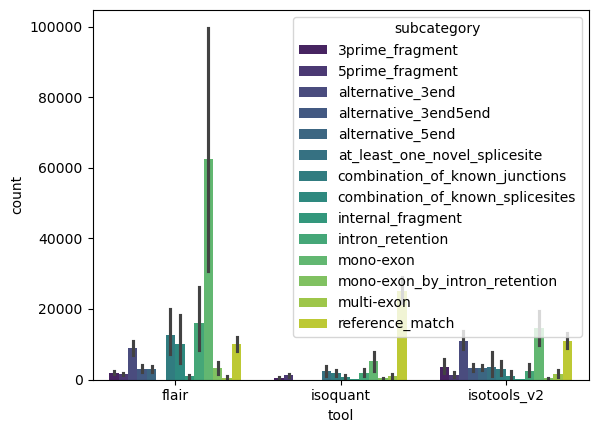

In [20]:
# Counts per subcategory
df = agg_by_subcategory.groupby(['tool', 'tissue', 'subcategory']).agg({'count': 'sum'}).reset_index()
ax1 = sns.barplot(x='tool', y='count', hue='subcategory', data=df, palette='viridis')
plt.show()
no_stringtie = ~df['tool'].isin(['stringtie'])
ax1 = sns.barplot(x='tool', y='count', hue='subcategory', data=df[no_stringtie], palette='viridis')

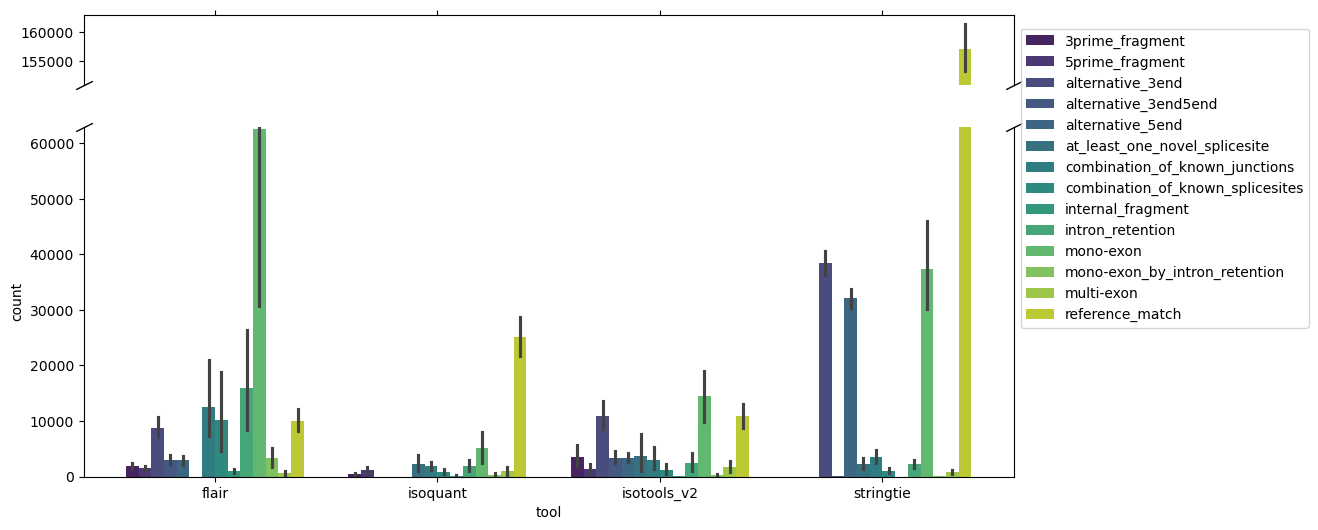

In [21]:
# split y between 40k and 140k
# move legend left outside the plot
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=(1, 5), figsize=(12, 6))
sns.barplot(x='tool', y='count', hue='subcategory', data=df, palette='viridis', ax=ax1, legend=False)
sns.barplot(x='tool', y='count', hue='subcategory', data=df, palette='viridis', ax=ax2)

ax1.set_ylabel('')

ax1.set_ylim(151_000, 163_000)  # outliers only
ax2.set_ylim(0, 63_000)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# Move legend outside the plot
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1.3), ncol=1)

plt.savefig(os.path.join(plot_directory, 'transcript_counts_subcategory.png'), bbox_inches='tight')
plt.show()

## ISM subcategory counts

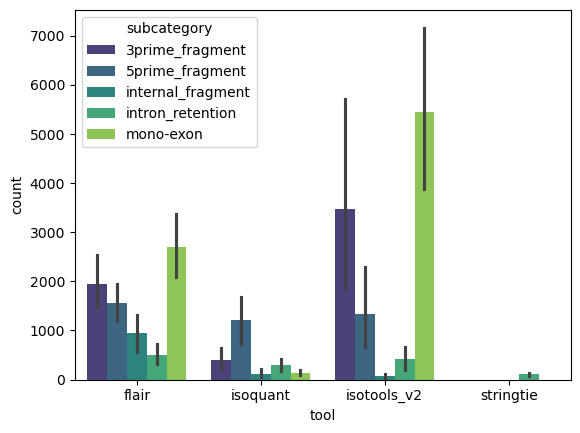

In [22]:
df = agg_by_subcategory.loc[agg_by_subcategory['category'] == 'ISM']
# Counts per subcategory
ax1 = sns.barplot(x='tool', y='count', hue='subcategory', data=df, palette='viridis')
plt.savefig(os.path.join(plot_directory, 'transcript_counts_subcategory_ISM.png'))

In [23]:
df

tool  tissue category        subcategory  TSS ratio  CAGE support  \
10       flair   aorta      ISM    3prime_fragment        426           106   
11       flair   aorta      ISM    5prime_fragment       1127           767   
12       flair   aorta      ISM  internal_fragment        108            23   
13       flair   aorta      ISM   intron_retention         96            55   
14       flair   aorta      ISM          mono-exon        332            66   
..         ...     ...      ...                ...        ...           ...   
461  stringtie   brain      ISM   intron_retention         77            50   
482  stringtie   colon      ISM   intron_retention         39            23   
503  stringtie   heart      ISM   intron_retention         80            35   
524  stringtie    lung      ISM   intron_retention         73            37   
545  stringtie  muscle      ISM   intron_retention         19            20   

     polyA site  polyA motif  start both  end both  isoform  count  
10         1298         1273          53      1123     1847   1847  
11          620          747         594       371     1784   1784  
12          143          270           6        67     1087   1087  
13          153          185          37       122      413    413  
14         2187         2193          15      1957     2817   2817  
..          ...          ...         ...       ...      ...    ...  
461         120          135          34       109      176    176  
482          58           65          20        56       71     71  
503         102          108          28        94      130    130  
524          90           92          30        81      120    120  
545          36           32          10        28       46     46  

[96 rows x 12 columns]

In [24]:
# Mean counts per category
agg_by_subcategory.groupby(['tool', 'subcategory']).agg(count_mean=('count', 'mean'), count_sd=('count', 'std')).reset_index()

tool                       subcategory     count_mean      count_sd
0         flair                   3prime_fragment    1940.166667    704.810164
1         flair                   5prime_fragment    1559.666667    505.583887
2         flair                  alternative_3end    8817.500000   2602.734159
3         flair              alternative_3end5end    3027.000000   1205.526275
4         flair                  alternative_5end    2940.333333   1069.021733
5         flair     at_least_one_novel_splicesite       7.833333      8.232051
6         flair    combination_of_known_junctions   12611.000000   8832.575570
7         flair  combination_of_known_splicesites   10151.833333  10081.965035
8         flair                 internal_fragment     947.333333    548.953793
9         flair                  intron_retention    3996.541667   8586.731544
10        flair                         mono-exon   10426.472222  14108.905148
11        flair     mono-exon_by_intron_retention    3292.333333   2357.692403
12        flair                        multi-exon     580.500000    536.297585
13        flair                   reference_match   10085.166667   2727.069153
14     isoquant                   3prime_fragment     407.666667    299.885089
15     isoquant                   5prime_fragment    1219.000000    669.117030
16     isoquant                  alternative_3end       4.000000      0.000000
17     isoquant              alternative_3end5end       2.000000           NaN
18     isoquant     at_least_one_novel_splicesite    2320.500000   1905.416884
19     isoquant    combination_of_known_junctions    1927.666667   1065.859966
20     isoquant  combination_of_known_splicesites     872.666667    602.966555
21     isoquant                 internal_fragment     117.000000    109.394698
22     isoquant                  intron_retention     493.083333    627.027835
23     isoquant                         mono-exon     868.500000   1099.346806
24     isoquant     mono-exon_by_intron_retention     349.500000    254.887230
25     isoquant                        multi-exon     197.733333    289.334186
26     isoquant                   reference_match   25096.500000   5049.855354
27  isotools_v2                   3prime_fragment    3475.166667   2733.254867
28  isotools_v2                   5prime_fragment    1339.500000   1140.163804
29  isotools_v2                  alternative_3end   10982.666667   3496.936640
30  isotools_v2              alternative_3end5end    3416.500000   1415.487584
31  isotools_v2                  alternative_5end    3395.833333   1163.235387
32  isotools_v2     at_least_one_novel_splicesite    3617.666667   5050.137609
33  isotools_v2    combination_of_known_junctions    2947.833333   2884.401873
34  isotools_v2  combination_of_known_splicesites    1145.666667   1419.639767
35  isotools_v2                 internal_fragment      63.166667     72.901075
36  isotools_v2                  intron_retention     641.565217   1019.792217
37  isotools_v2                         mono-exon    2414.888889   2250.628113
38  isotools_v2     mono-exon_by_intron_retention     354.333333    222.098777
39  isotools_v2                        multi-exon     336.933333    626.146669
40  isotools_v2                   reference_match   10977.000000   2996.413723
41    stringtie                  alternative_3end   38403.666667   2974.906766
42    stringtie              alternative_3end5end      50.833333      3.656045
43    stringtie                  alternative_5end   32117.500000   2666.248132
44    stringtie     at_least_one_novel_splicesite    2265.833333   1430.627473
45    stringtie    combination_of_known_junctions    3572.166667   1647.497304
46    stringtie  combination_of_known_splicesites    1045.166667    582.798564
47    stringtie                  intron_retention     573.916667    724.401577
48    stringtie                         mono-exon    9342.166667  10805.396283
49    stringtie     mono-exon_by_intron_retention     119.166

# All

In [25]:
def heatmap(df: pd.DataFrame, column, header_suffix='', export_name=None, **params):
    df = df.copy()
    df.loc[:,'relative_metric'] = df[column] / df['count']
    df.loc[:,'annotation'] = df['relative_metric'].map('{:,.1%}'.format) + \
                            '\n(' + df[column].astype(str) + '/' + df['count'].astype(str) + ')'
    # Reshape the data using pivot
    heatmap_data = df.pivot(index='tool', columns='tissue', values='relative_metric')
    # get max value for each tissue
    max_values = heatmap_data.max(axis=0)

    # Annotate each cell with the numeric value and the count
    annot = df.pivot(index='tool', columns='tissue', values='annotation')

    # Plot the heatmap
    plt.figure(figsize=(12, 1 + len(df['tool'].unique())))
    ax = sns.heatmap(heatmap_data, vmin=0, vmax=1, annot=annot, fmt='', linewidths=0.5, **params)
    # Make max values bold
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if heatmap_data.iloc[i, j] == max_values.iloc[j]:
                ax.texts[i * len(heatmap_data.columns) + j].set_fontweight('bold')

    # plt.title(f'Heatmap of {column}{header_suffix}')
    plt.xlabel('Tissue')
    plt.ylabel('Tool')
    if export_name:
        plt.savefig(os.path.join(plot_directory, f'{export_name}.png'), bbox_inches='tight')
    plt.show()

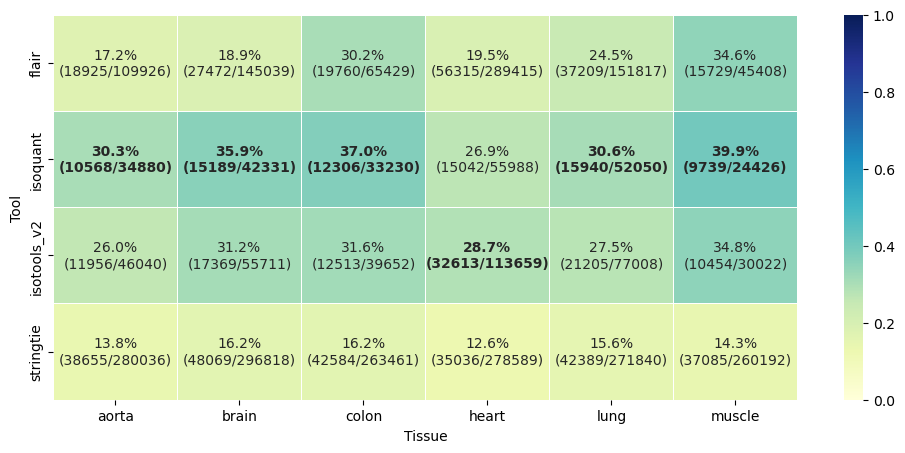

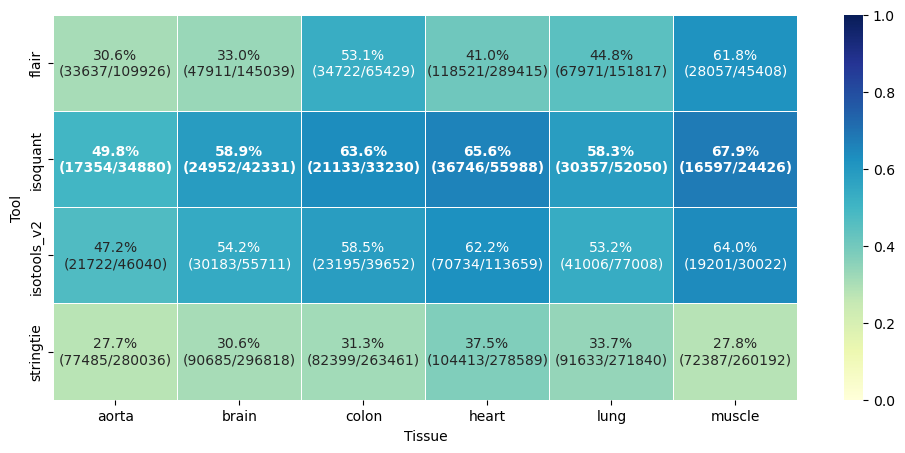

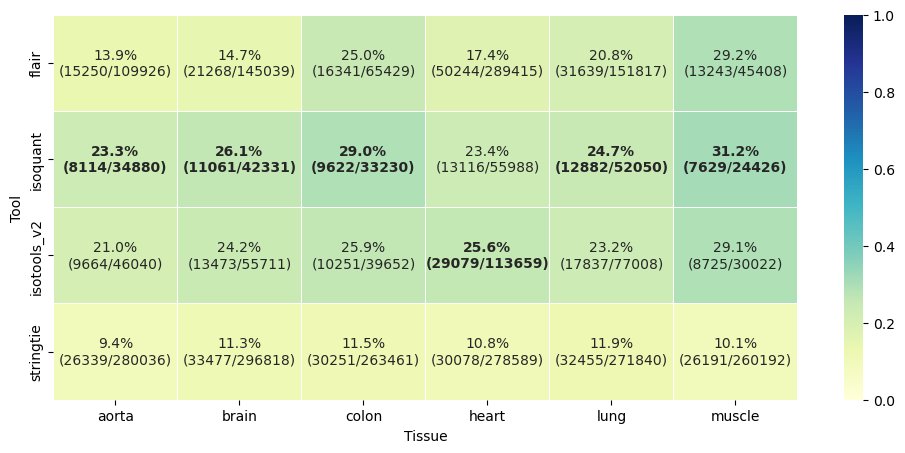

In [26]:
heatmap(agg_all, 'CAGE support', export_name='CAGE_support', cmap='YlGnBu')
heatmap(agg_all, 'TSS ratio', export_name='TSS_ratio', cmap='YlGnBu')
heatmap(agg_all, 'start both', cmap='YlGnBu')

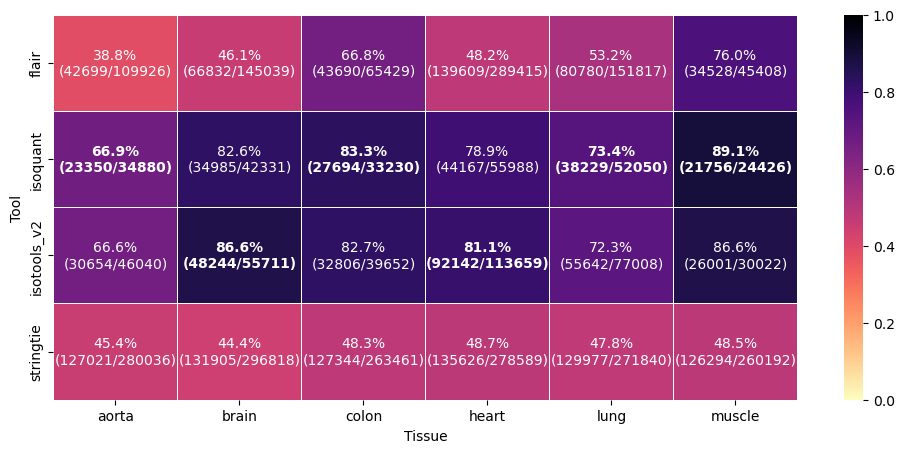

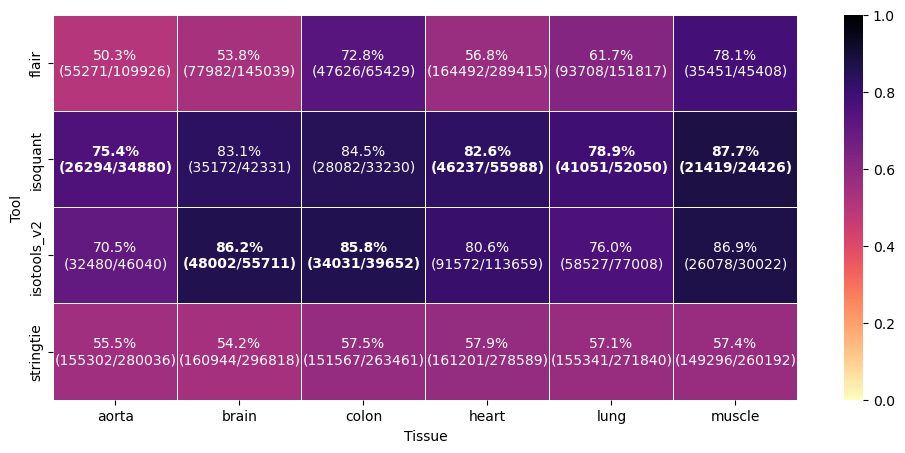

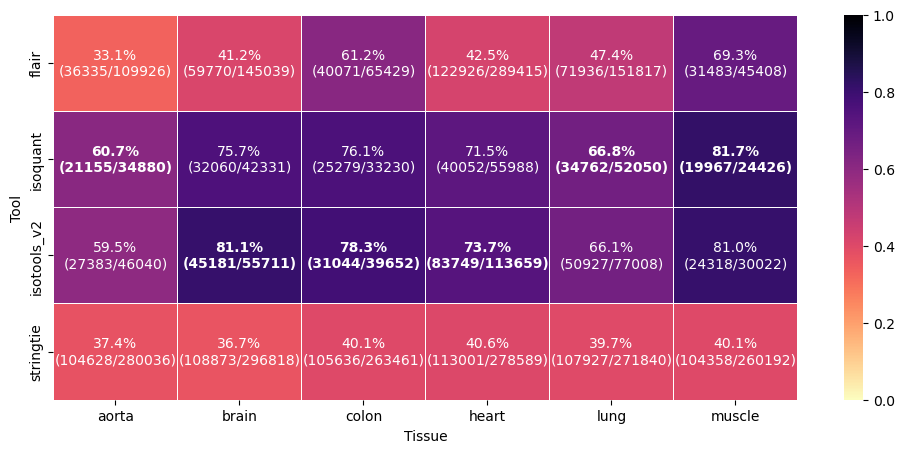

In [27]:
heatmap(agg_all, 'polyA site', export_name='PolyA_site', cmap='magma_r')
heatmap(agg_all, 'polyA motif', export_name='PolyA_motif', cmap='magma_r')
heatmap(agg_all, 'end both', cmap='magma_r')

# By Category

In [28]:
non_fsm_df = agg_by_category.loc[agg_by_category['category'] != 'FSM'].groupby(['tissue', 'tool']).sum().reset_index()

## Starts

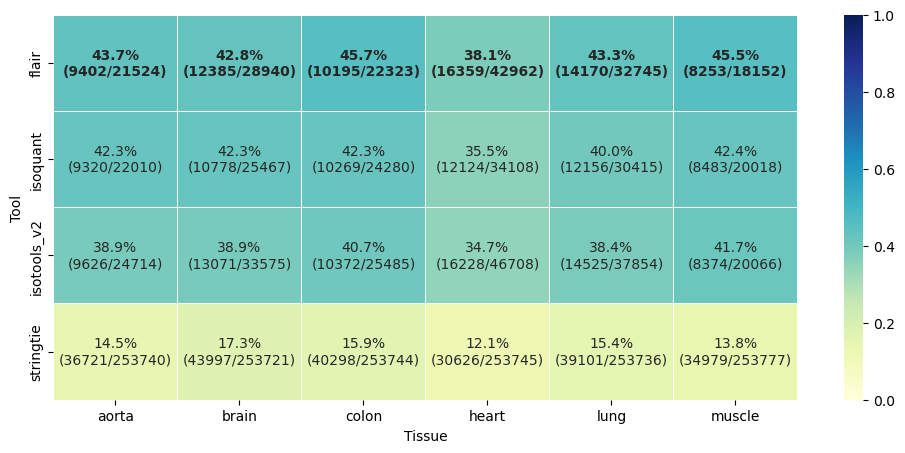

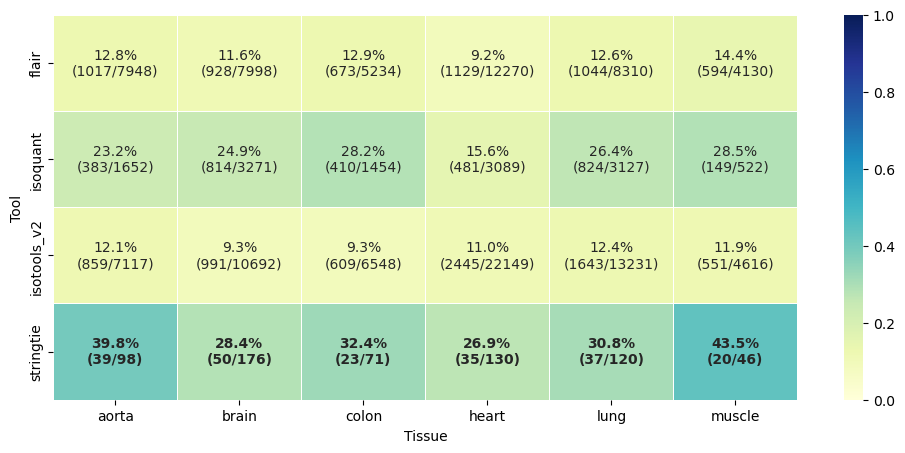

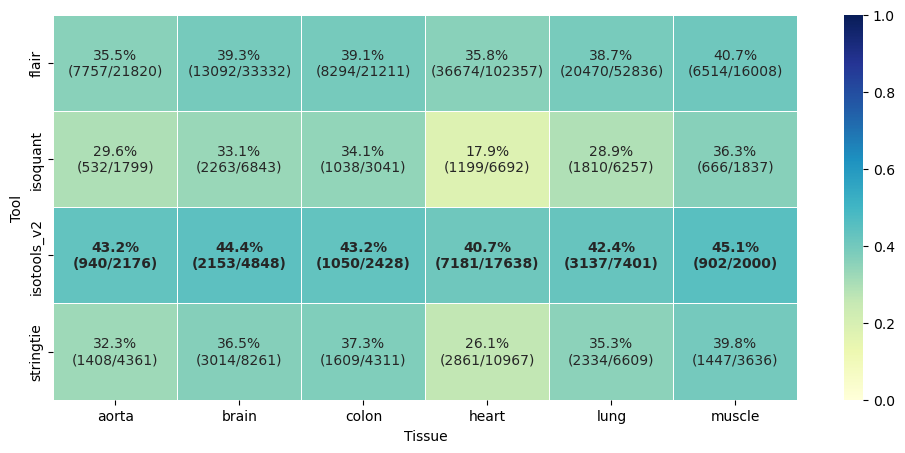

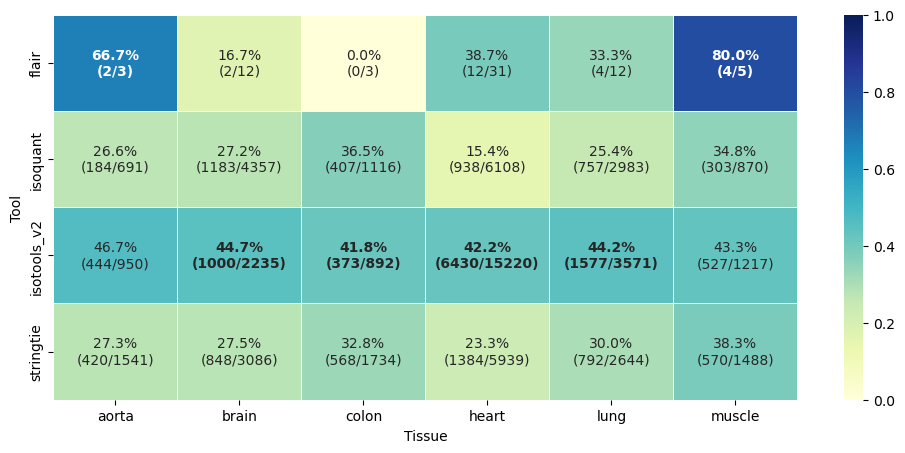

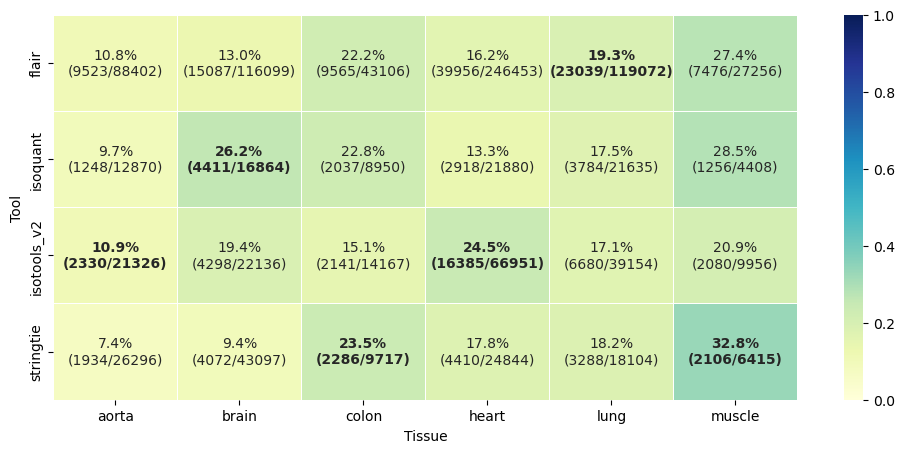

In [29]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'CAGE support', ' for FSM', export_name='CAGE_support_FSM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'CAGE support', ' for ISM', export_name='CAGE_support_ISM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NIC'], 'CAGE support', ' for NIC', export_name='CAGE_support_NIC', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NNC'], 'CAGE support', ' for NNC', export_name='CAGE_support_NNC', cmap='YlGnBu')
heatmap(non_fsm_df, 'CAGE support', ' for non-FSM', export_name='CAGE_support_non_FSM', cmap='YlGnBu')

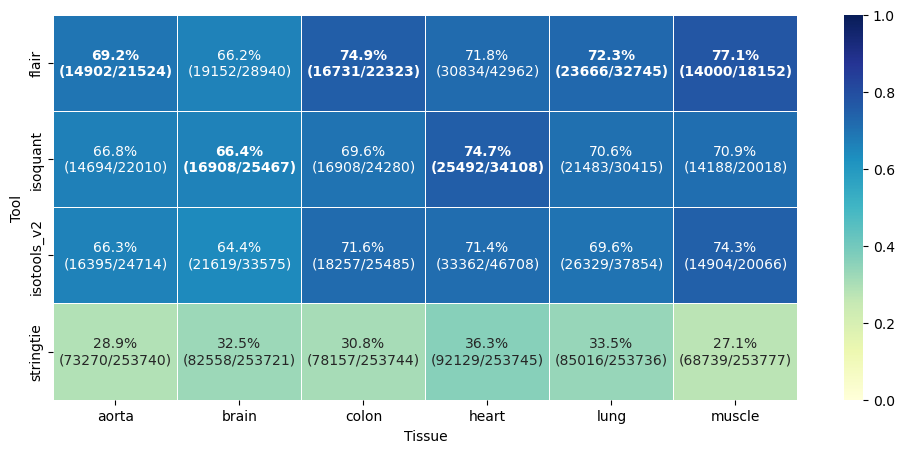

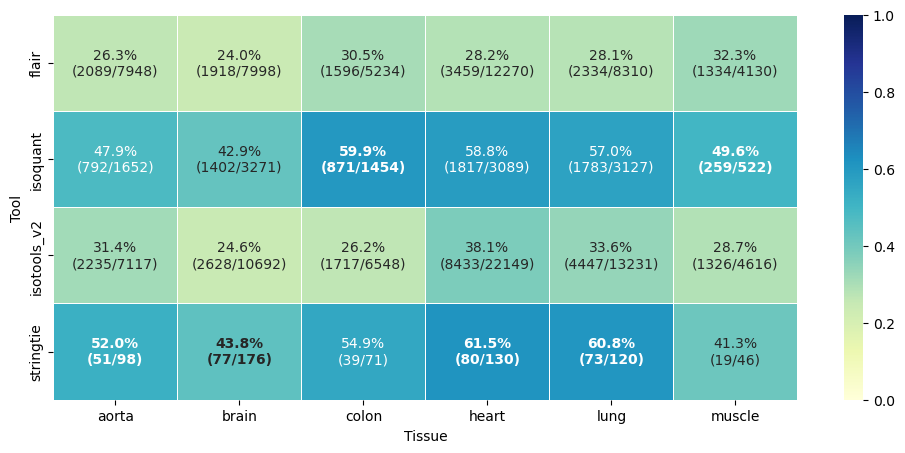

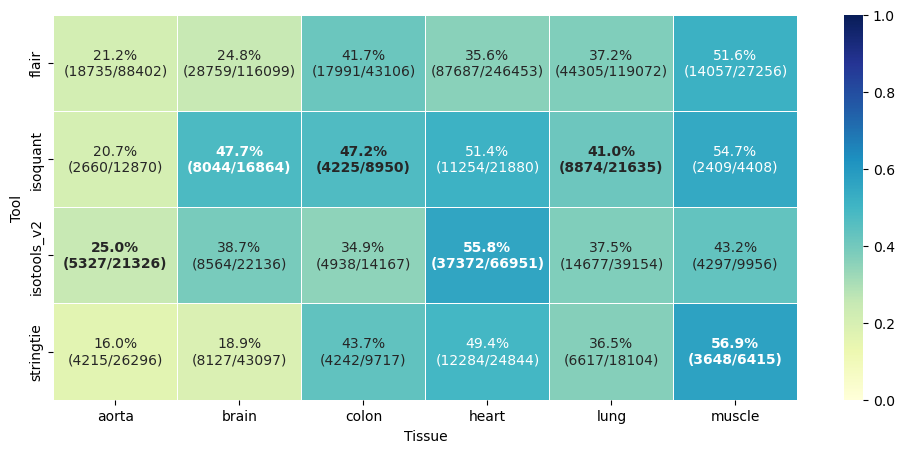

In [30]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'TSS ratio', ' for FSM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'TSS ratio', ' for ISM', cmap='YlGnBu')
heatmap(non_fsm_df, 'TSS ratio', ' for non-FSM', cmap='YlGnBu')

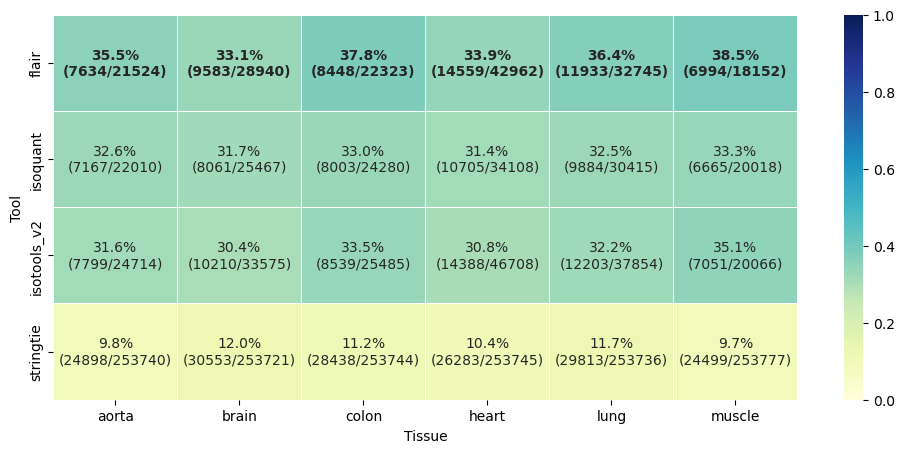

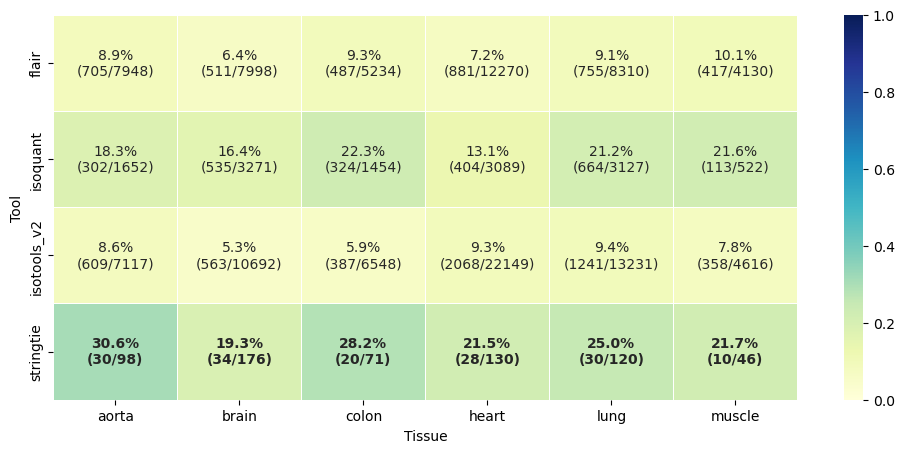

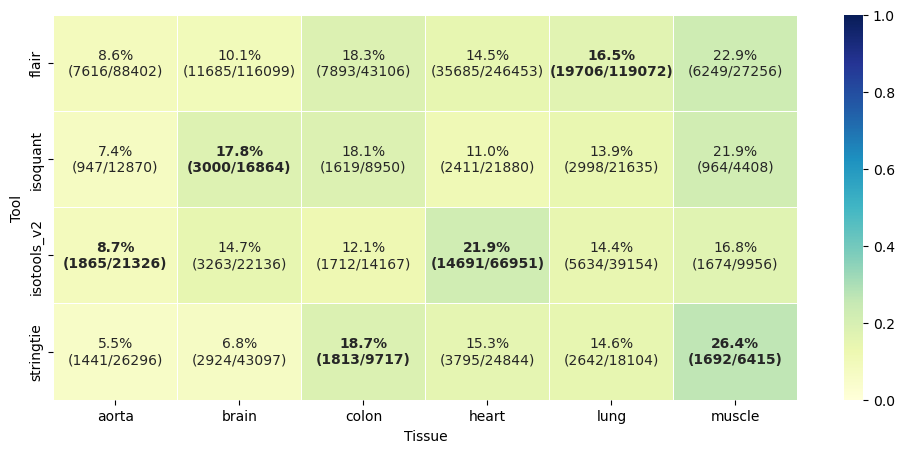

In [31]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'start both', ' for FSM', cmap='YlGnBu')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'start both', ' for ISM', cmap='YlGnBu')
heatmap(non_fsm_df, 'start both', ' for non-FSM', cmap='YlGnBu')

## Ends

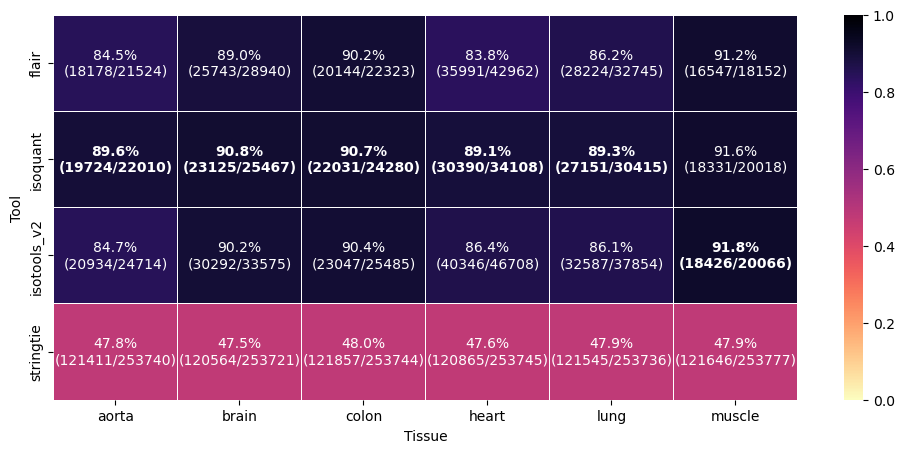

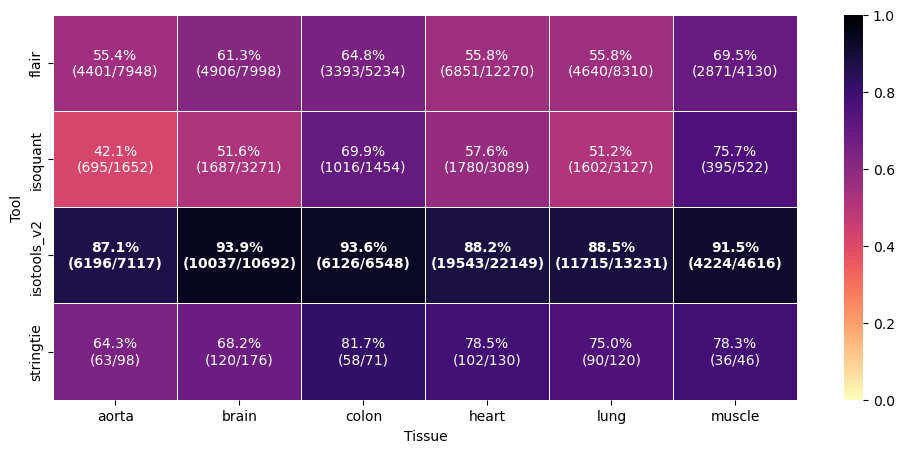

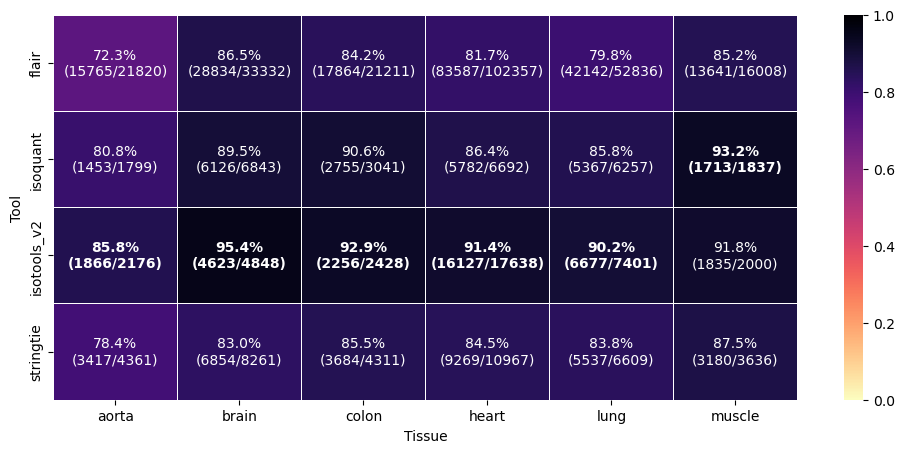

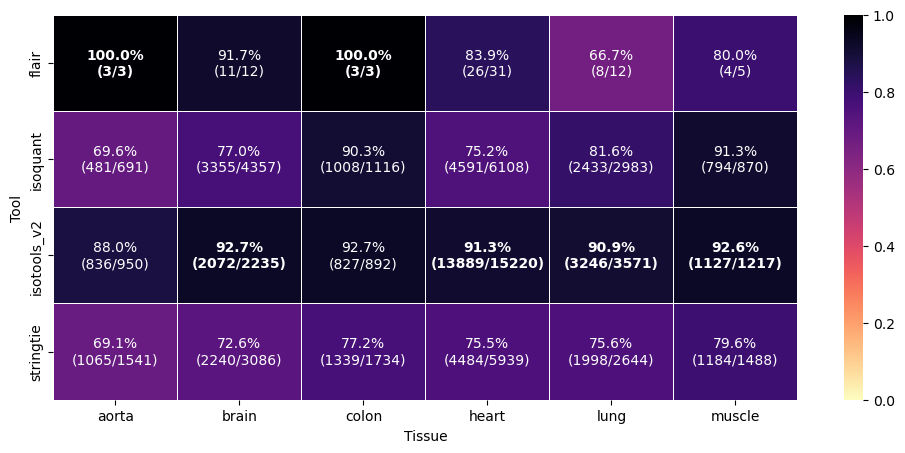

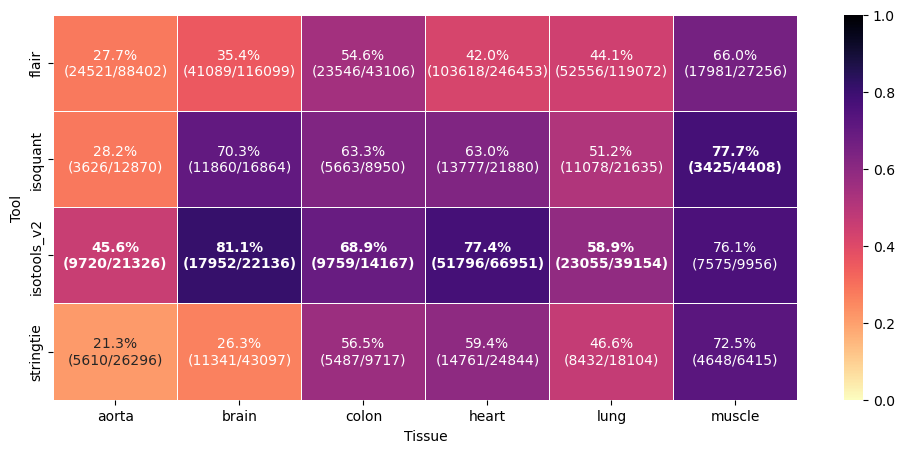

In [32]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'polyA site', ' for FSM', export_name="polyA_site_FSM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'polyA site', ' for ISM', export_name="polyA_site_ISM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NIC'], 'polyA site', ' for NIC', export_name="polyA_site_NIC", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NNC'], 'polyA site', ' for NNC', export_name="polyA_site_NNC", cmap='magma_r')
heatmap(non_fsm_df, 'polyA site', ' for non-FSM', cmap='magma_r')

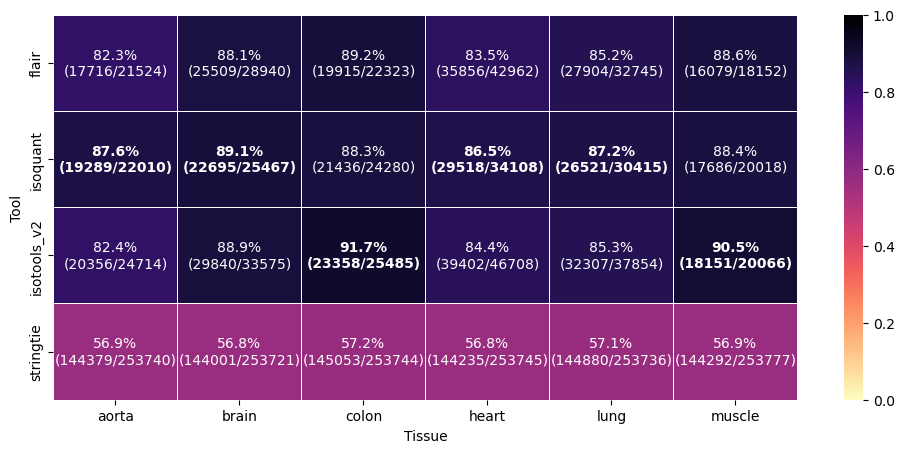

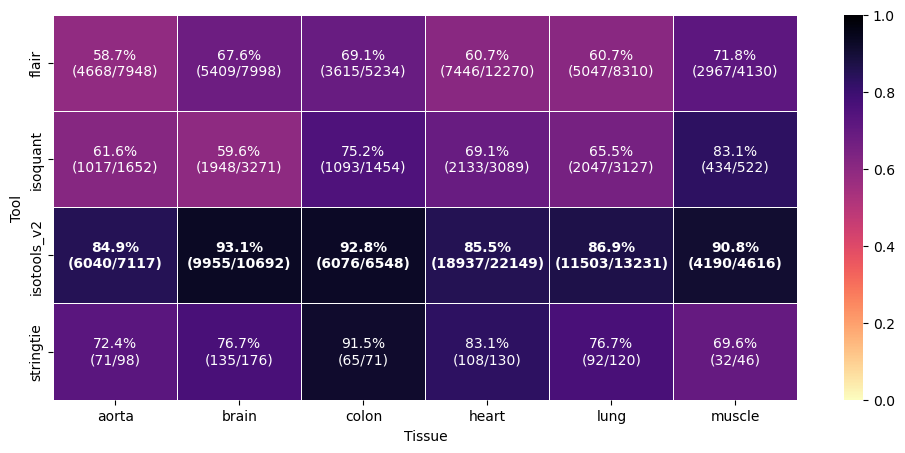

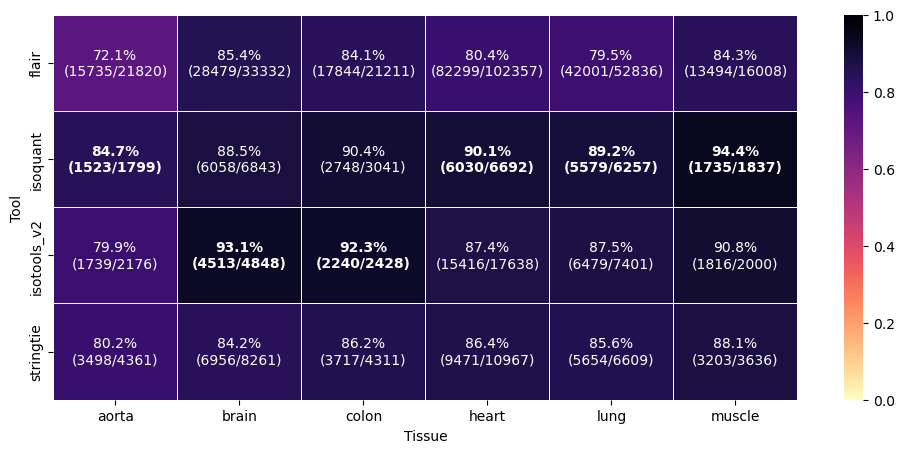

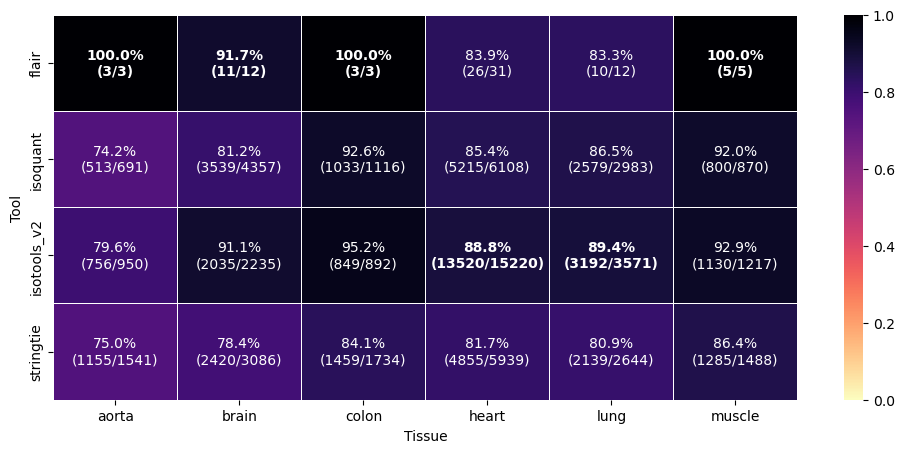

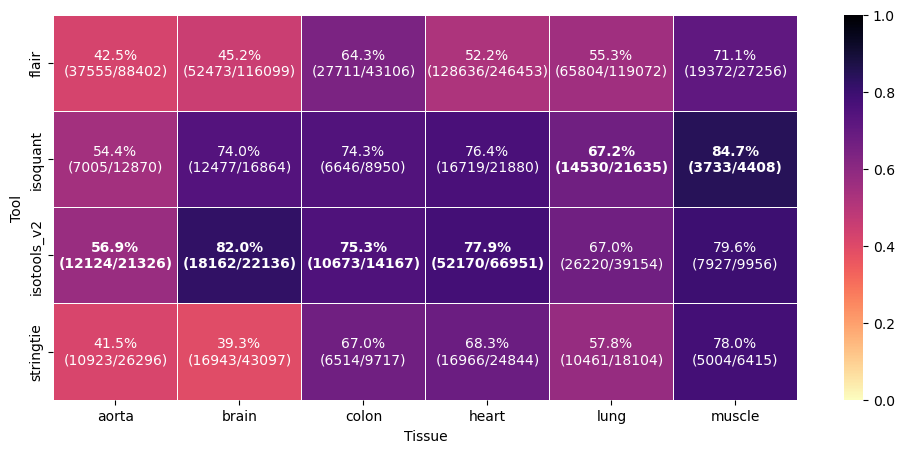

In [33]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'polyA motif', ' for FSM', export_name="polyA_motif_FSM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'polyA motif', ' for ISM', export_name="polyA_motif_ISM", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NIC'], 'polyA motif', ' for NIC', export_name="polyA_motif_NIC", cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'NNC'], 'polyA motif', ' for NNC', export_name="polyA_motif_NNC", cmap='magma_r')
heatmap(non_fsm_df, 'polyA motif', ' for non-FSM', cmap='magma_r')

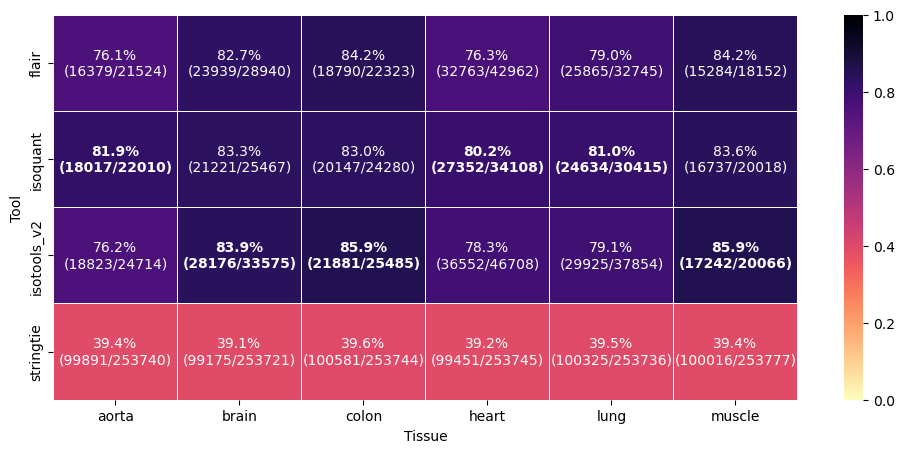

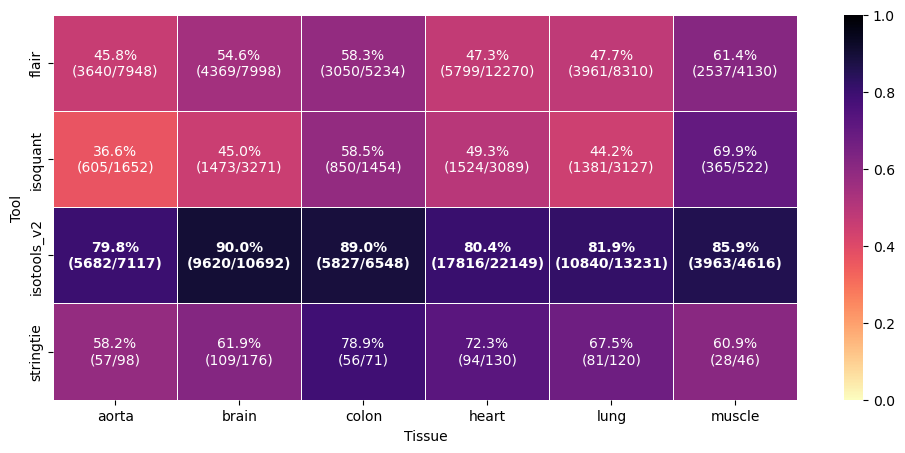

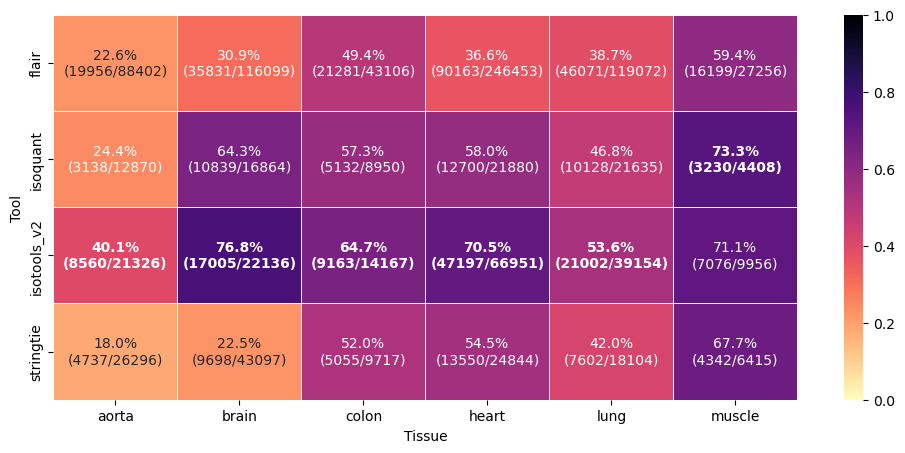

In [34]:
heatmap(agg_by_category.loc[agg_by_category['category'] == 'FSM'], 'end both', ' for FSM', cmap='magma_r')
heatmap(agg_by_category.loc[agg_by_category['category'] == 'ISM'], 'end both', ' for ISM', cmap='magma_r')
heatmap(non_fsm_df, 'end both', ' for non-FSM', cmap='magma_r')

# Subcategory

## Only Monoexons

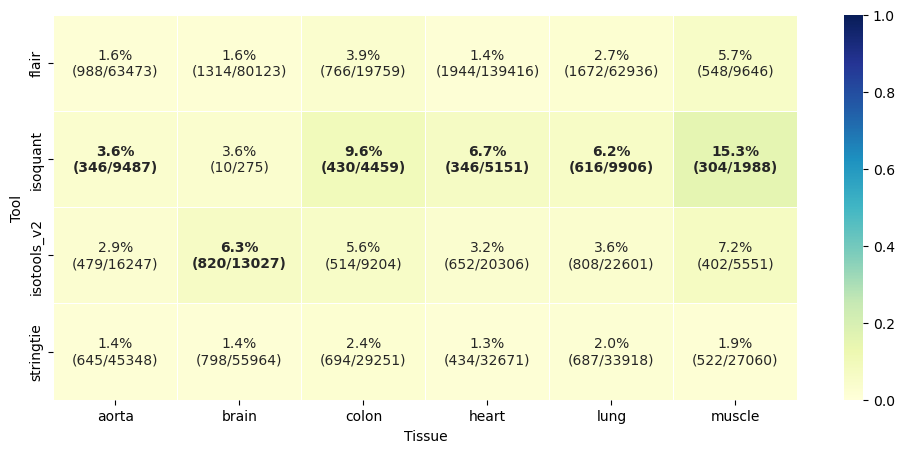

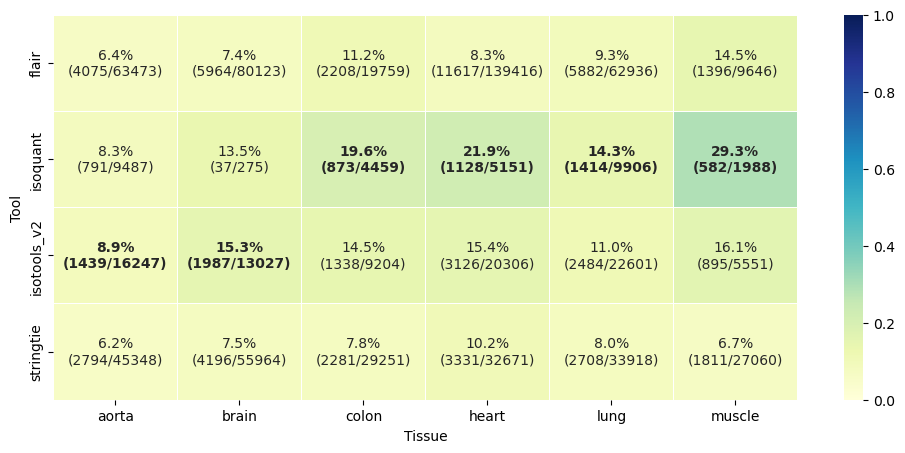

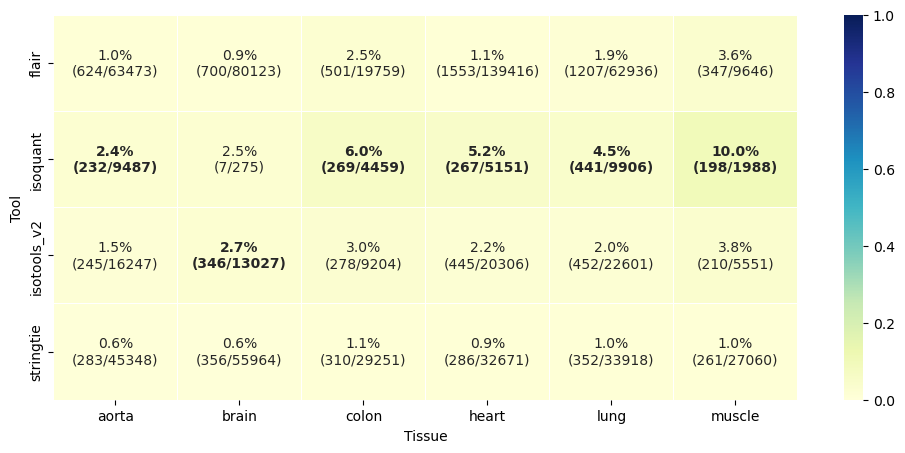

In [35]:
mono_exons = agg_by_subcategory.loc[agg_by_subcategory['subcategory'] == 'mono-exon'].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(mono_exons, 'CAGE support', ' for Monoexons', export_name='CAGE_support_monoexons', cmap='YlGnBu')
heatmap(mono_exons, 'TSS ratio', ' for Monoexons', cmap='YlGnBu')
heatmap(mono_exons, 'start both', ' for Monoexons', cmap='YlGnBu')

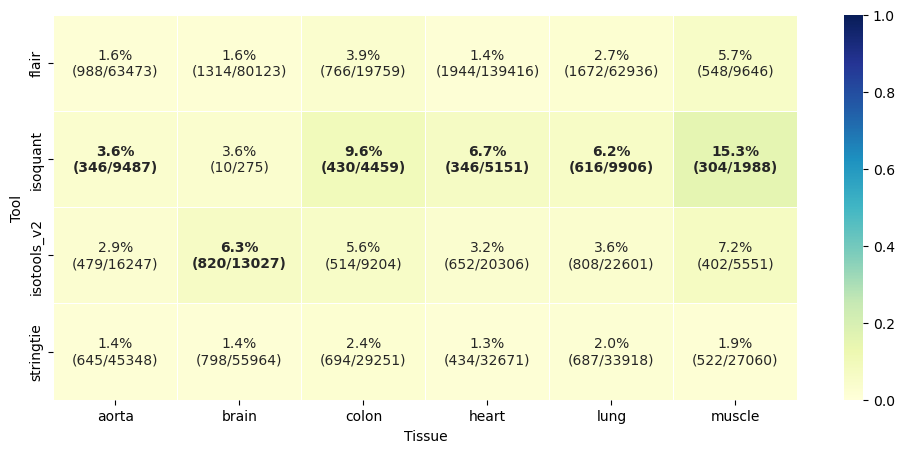

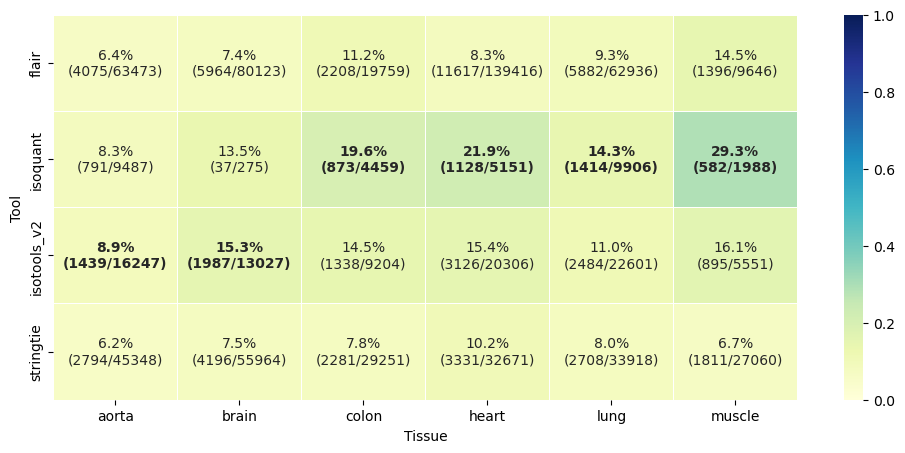

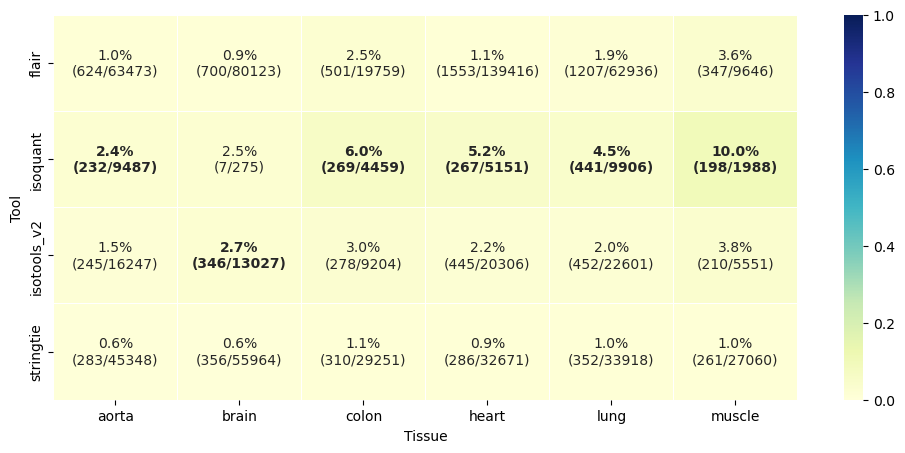

In [36]:
mono_exons = agg_by_subcategory.loc[agg_by_subcategory['subcategory'] == 'mono-exon'].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(mono_exons, 'CAGE support', ' for Monoexons', export_name='CAGE_support_monoexons', cmap='YlGnBu')
heatmap(mono_exons, 'TSS ratio', ' for Monoexons', cmap='YlGnBu')
heatmap(mono_exons, 'start both', ' for Monoexons', cmap='YlGnBu')

## ISM w/o Monoexons

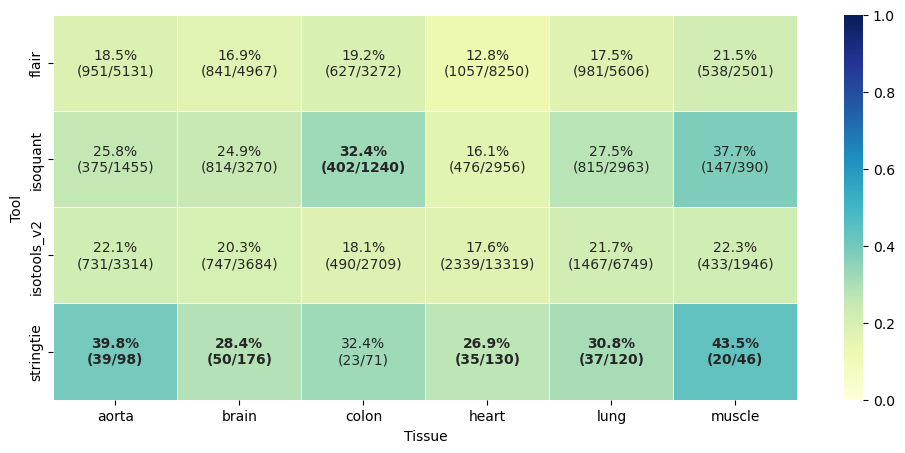

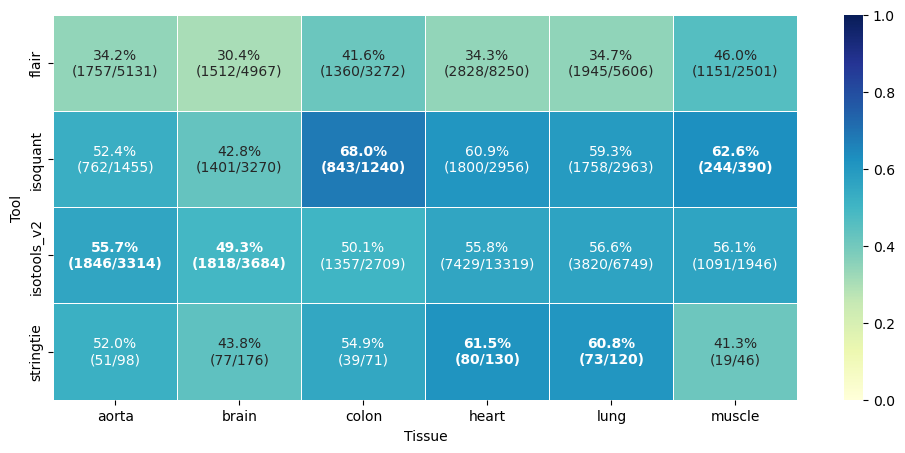

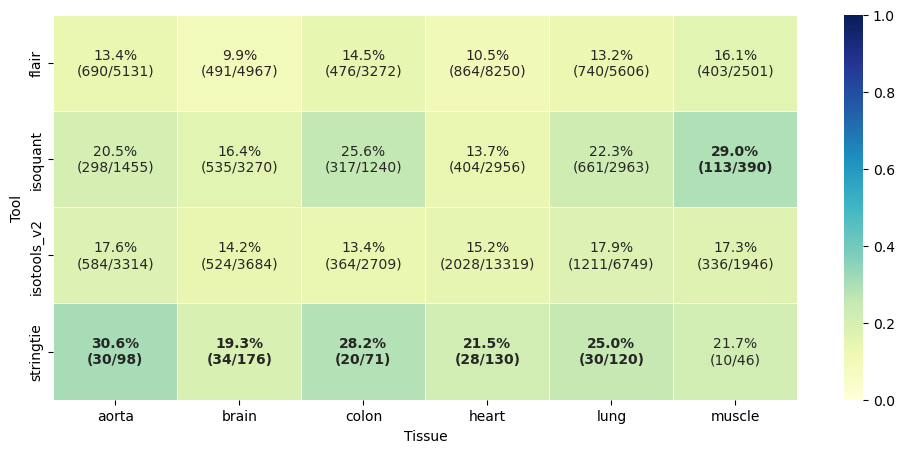

In [37]:
no_mono_ISM = agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['category'] == 'ISM')].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(no_mono_ISM, 'CAGE support', ' for ISM w/o Monoexons', export_name='CAGE_support_ISM_no_monoexons', cmap='YlGnBu')
heatmap(no_mono_ISM, 'TSS ratio', ' for ISM w/o Monoexons', cmap='YlGnBu')
heatmap(no_mono_ISM, 'start both', ' for ISM w/o Monoexons', cmap='YlGnBu')

# All w/o Monoexons

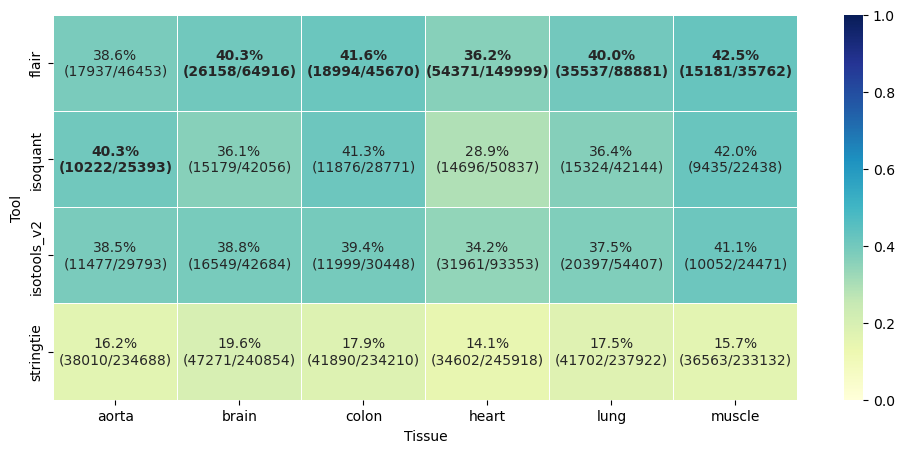

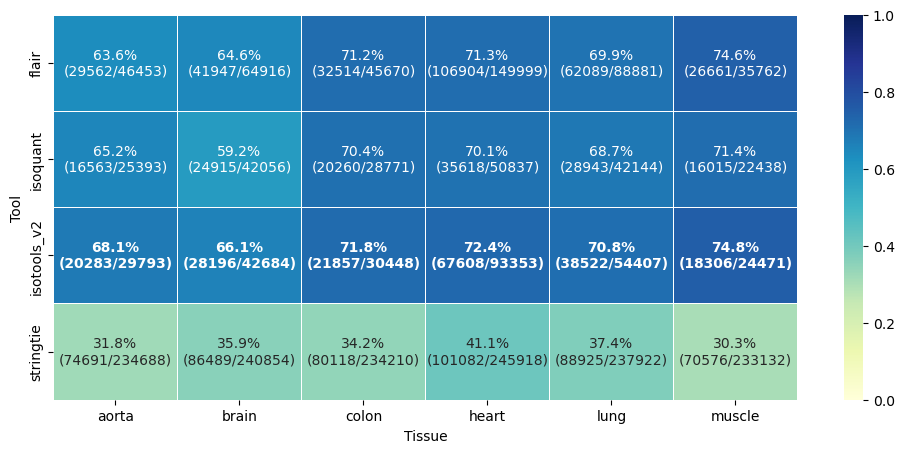

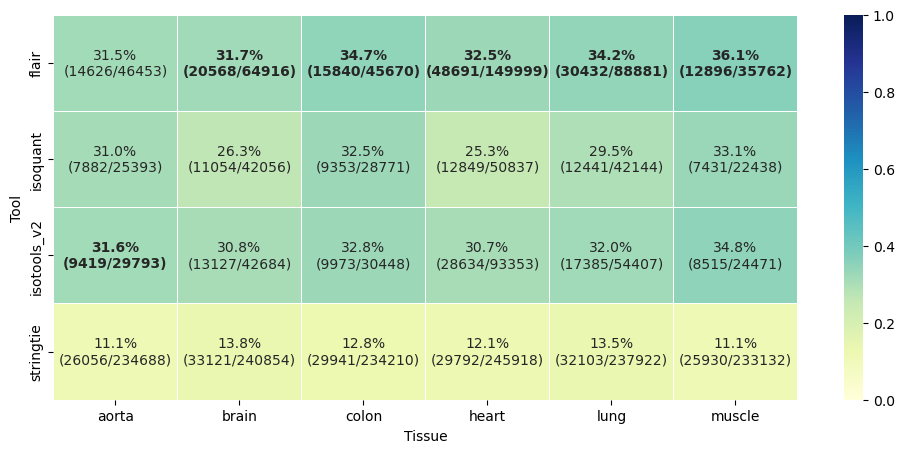

In [38]:
no_mono_all = agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon')].groupby(['tissue', 'tool']).sum().reset_index()
heatmap(no_mono_all, 'CAGE support', ' w/o Monoexons', export_name='CAGE_support_no_monoexons', cmap='YlGnBu')
heatmap(no_mono_all, 'TSS ratio', ' w/o Monoexons', cmap='YlGnBu')
heatmap(no_mono_all, 'start both', ' w/o Monoexons', cmap='YlGnBu')

# No monoexons and 3' fragments

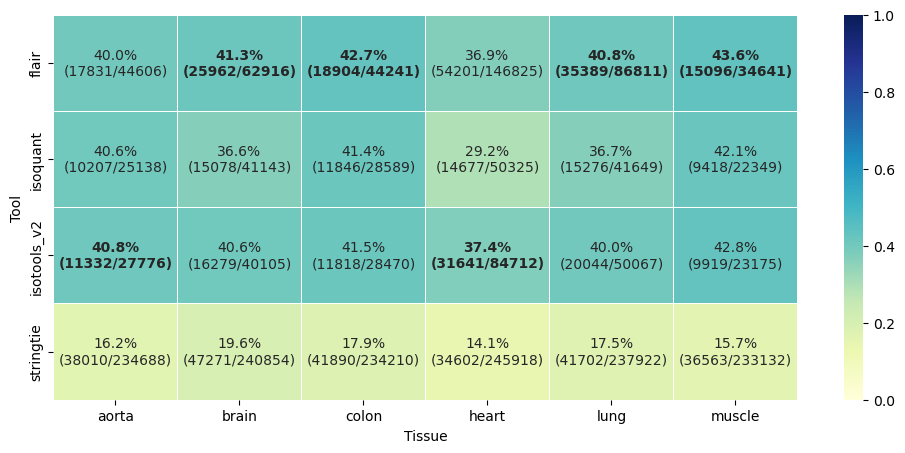

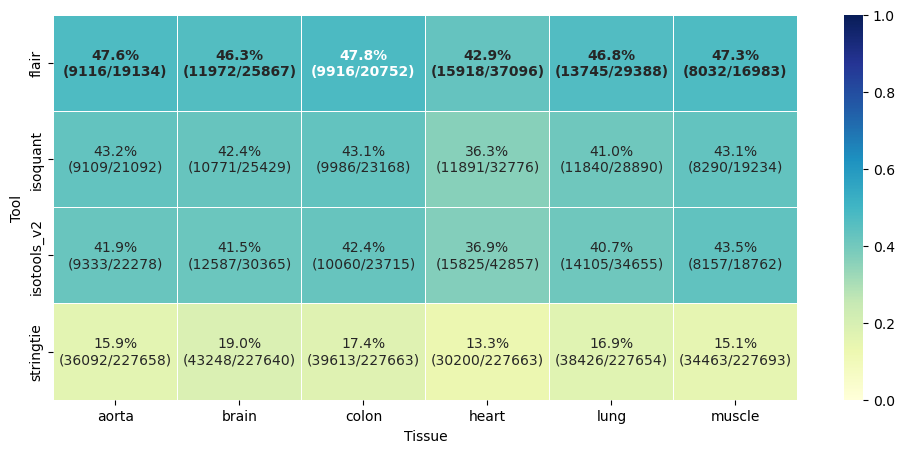

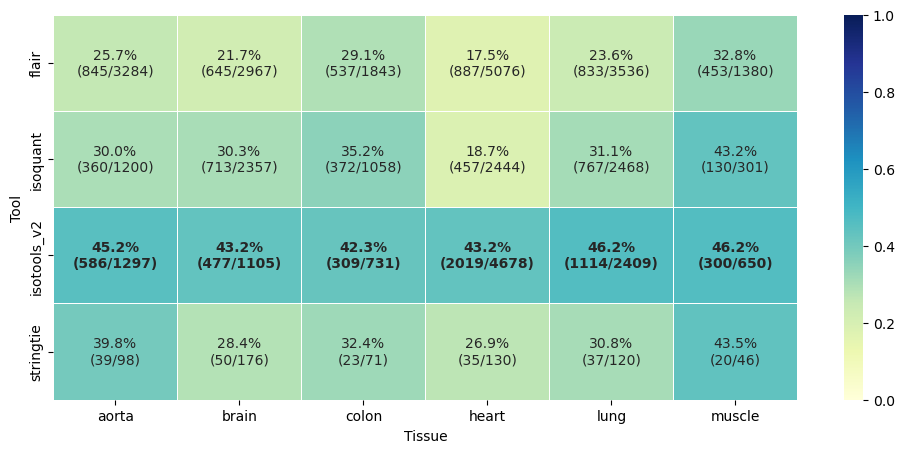

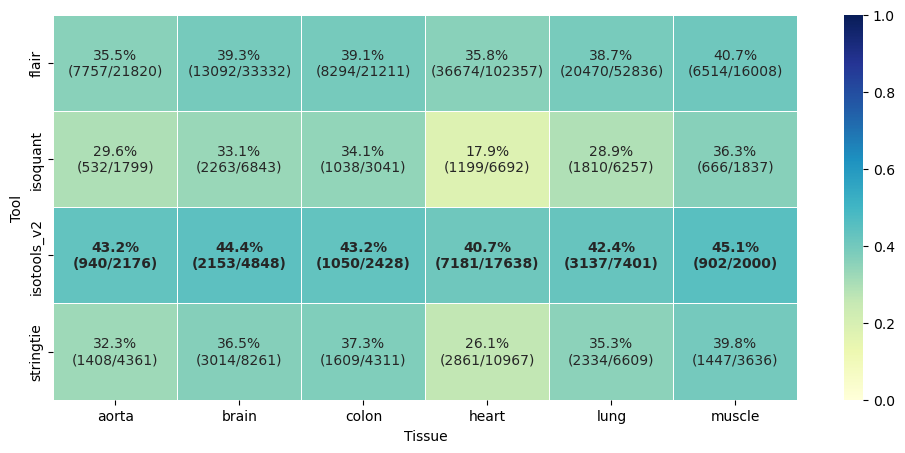

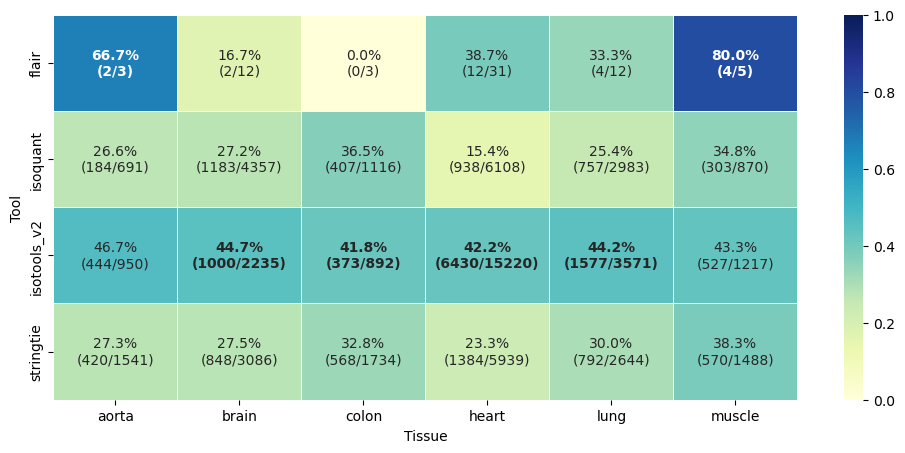

In [39]:
heatmap(agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['subcategory'] != '3prime_fragment')].groupby(['tissue', 'tool']).sum().reset_index(), 'CAGE support', ' w/o Monoexons and 3\' Fragments', export_name='CAGE_support_no_monoexons_no_3fragment', cmap='YlGnBu')
heatmap(agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['subcategory'] != '3prime_fragment') & (agg_by_subcategory['category'] == 'FSM')].groupby(['tissue', 'tool']).sum().reset_index(), 'CAGE support', ' w/o Monoexons and 3\' Fragments', export_name='CAGE_support_FSM_no_monoexons_no_3fragment', cmap='YlGnBu')
heatmap(agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['subcategory'] != '3prime_fragment') & (agg_by_subcategory['category'] == 'ISM')].groupby(['tissue', 'tool']).sum().reset_index(), 'CAGE support', ' w/o Monoexons and 3\' Fragments', export_name='CAGE_support_ISM_no_monoexons_no_3fragment', cmap='YlGnBu')
heatmap(agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['subcategory'] != '3prime_fragment') & (agg_by_subcategory['category'] == 'NIC')].groupby(['tissue', 'tool']).sum().reset_index(), 'CAGE support', ' w/o Monoexons and 3\' Fragments', export_name='CAGE_support_NIC_no_monoexons_no_3fragment', cmap='YlGnBu')
heatmap(agg_by_subcategory.loc[(agg_by_subcategory['subcategory'] != 'mono-exon') & (agg_by_subcategory['subcategory'] != '3prime_fragment') & (agg_by_subcategory['category'] == 'NNC')].groupby(['tissue', 'tool']).sum().reset_index(), 'CAGE support', ' w/o Monoexons and 3\' Fragments', export_name='CAGE_support_NNC_no_monoexons_no_3fragment', cmap='YlGnBu')

# Correlation

In [40]:
from scipy.stats import pearsonr

def correlation(df: pd.DataFrame, column1, column2):
    df = df.copy()
    df = df.loc[df['count'] > 0]
    # Calculate the correlation
    corr, p = pearsonr(df[column1], df[column2])
    print(f'Correlation between {column1} and {column2}: {corr:.3f} (p={p:.2e})')

correlation(agg_all, 'CAGE support', 'TSS ratio')
correlation(agg_all, 'polyA motif', 'polyA site')

Correlation between CAGE support and TSS ratio: 0.966 (p=2.18e-14)
Correlation between polyA motif and polyA site: 0.997 (p=1.66e-25)
